### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータ($\epsilon$と$\sigma$)を学習する

### 必要なパッケージを読み込む

In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using Distributions

### ポテンシャルエネルギー関数の定義

In [2]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

function sum_compute_energy(coords, epsilon, sigma)
    U = 0
    for i in 1:size(coords, 1)
        for j in (i+1):size(coords, 1)
            U += compute_energy(coords[i], coords[j], epsilon, sigma)
        end
    end
    return U
end

sum_compute_energy (generic function with 1 method)

In [3]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

### ポテンシャルエネルギー関数を持つFluxのカスタムレイヤの定義

In [4]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(coords) = sum_compute_energy(coords, m.P[1], m.P[2])

In [5]:
# カスタムレイヤでポテンシャルエネルギー値を計算できるかテスト
m = Energy([1.0, 1.0])
coords = ([0.0, 0.0, 0.0], [2.0, 0.0, 0.0], [1.0, 0.0, 0.0])
m(coords)

-2.031005859375

### MCMCの定義

In [6]:
#次のステップ候補点
function next_coords(coords, delta_x=1e-2)
    next_coords = map(x -> x .+ (rand(3) .- 0.5) .* delta_x, coords)
    return next_coords
end

next_coords (generic function with 2 methods)

In [7]:
#MCMC,メトロポリス法
function mcmc(coords, epsilon, sigma, nstep=100, beta=1.0)
    coords_trj = []
    alpha_trj = []
    push!(coords_trj, copy.(coords))
    
    for i in 1:nstep
        next_coords_tmp = next_coords(coords) #候補点
        delta_U = sum_compute_energy(next_coords_tmp, epsilon, sigma) - sum_compute_energy(coords, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha > rand()
            coords = next_coords_tmp
        end     
        push!(coords_trj, copy.(coords))
        push!(alpha_trj, alpha)
    end
    return coords_trj, alpha_trj
end

mcmc (generic function with 3 methods)

### 訓練データの作成

In [8]:
#パラメータ
param_set = [(1.0, 2.0), (3.0, 2.0),(10.0, 2.0), (1.0, 0.5), (8.0, 10.0)] #params_set[i] = (epsilon[i], sigma[i])

use_param = 5 #使うパラメータ
epsilon_true = param_set[use_param][1]
sigma_true = param_set[use_param][2]

natom = 7
coords = tuple([[10.0 * x + rand(), rand(), rand()] for x in 1:natom]...)  #初期座標

#kB = 1.380649e-23 #ボルツマン定数
kBT = 2.0
beta = 1.0/(kBT)

#seed_value = 123 #乱数固定
#Random.seed!(seed_value)

X_train = []
y_train = []
nstep = 10000

#nstepのMCMC
coords_trj, alpha = mcmc(coords, epsilon_true, sigma_true, nstep, beta)
X_train = coords_trj
y_train = sum_compute_energy.(X_train, epsilon_true, sigma_true)

10001-element Vector{Float64}:
 -45.27821472584094
 -45.29772581770281
 -45.315965760454716
 -45.23024573981243
 -45.18454014667223
 -45.14109747341219
 -45.14865600434608
 -45.10308416857458
 -45.03235865943113
 -44.99515770198453
 -44.98923324562806
 -44.988198789689946
 -44.946273169003085
   ⋮
 -45.084104676495116
 -45.10169337382588
 -45.163322331799876
 -45.23467141601154
 -45.26350316529549
 -45.27512731791513
 -45.22073981305047
 -45.19375209843628
 -45.21433214324528
 -45.22367182234646
 -45.2546663070502
 -45.281429947083495

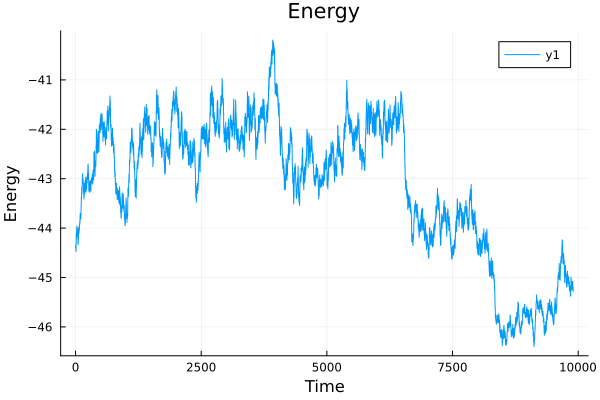

In [9]:
plot_point = 10000
plot_step = Int(floor(nstep/plot_point))

plot(y_train[100:plot_step:end],title="Energy",
    xlabel="Time", ylabel="Energy")

In [10]:
plot_step

1

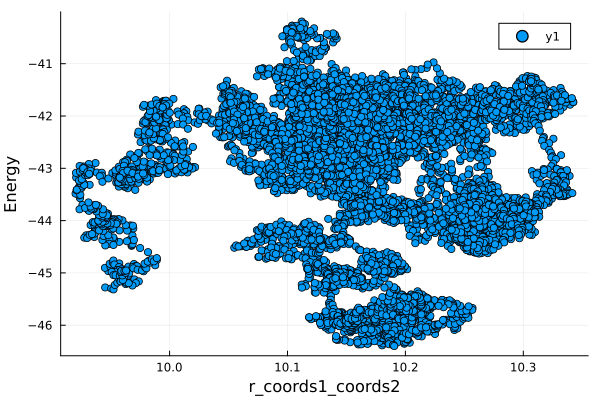

In [11]:
coords1_trj = [x[1] for x in coords_trj]
coords2_trj = [x[2] for x in coords_trj]
r = [sqrt(sum(x .^2)) for x in (coords1_trj - coords2_trj)]
scatter(r[1:plot_step:end], y_train[1:plot_step:end],
    ylabel="Energy",xlabel="r_coords1_coords2")

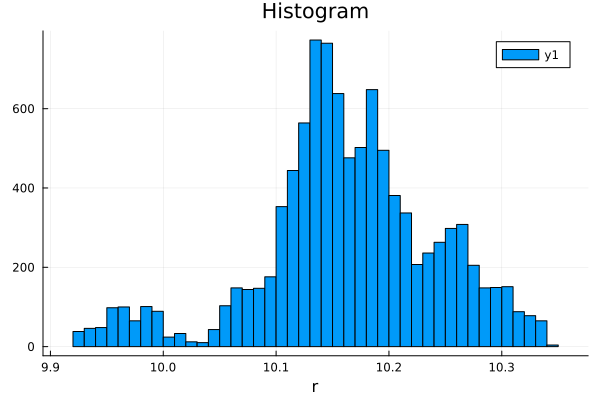

In [12]:
histogram(r[1:plot_step:end],title="Histogram",
        xlabel="r")

### 勾配法で訓練してK(バネ定数)とR(平衡長)を推定

In [13]:
# Lossの定義
m = Energy([0.1, 0.1])
loss(X, y) = Flux.Losses.mse(mean(m.(X)), mean(y))
loss(X_train, y_train)

1860.6676059737154

In [14]:
m(X_train[1])

-1.2575876389952594e-12

In [15]:
# DataやOptimizerの定義
train_loader = Flux.Data.DataLoader((data=X_train, label=y_train), batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-3) 

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [16]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

print_callback (generic function with 1 method)

In [17]:
# 訓練
loss_train = []

for epoch in 1:20
    for (X, y) in train_loader
        gs = gradient(() -> loss(X, y), ps)
        Flux.Optimise.update!(opt, ps, gs)
    end
    push!(loss_train, loss(X_train, y_train))
    if epoch%2 == 1
        print_callback(epoch, loss(X_train, y_train), ps)
    end
end

Epoch: 1, loss: 1859.1132232158363
param: [2.7595324288005068, 2.8323222341392094]
Epoch: 3, loss: 862.7683892644492
param: [7.3459674648865505, 7.393737520869909]
Epoch: 5, loss: 1.7154955145994075
param: [9.09135755042122, 8.958544795707862]
Epoch: 7, loss: 0.0004423553344307729
param: [9.169665303916217, 9.01876284009425]
Epoch: 9, loss: 0.0001233224806223028
param: [9.16158718504695, 9.020533924557867]
Epoch: 11, loss: 0.0008824052236885278
param: [9.14160673815363, 9.023905377838767]
Epoch: 13, loss: 0.01022926371687539
param: [9.125636589134297, 9.037028897564356]
Epoch: 15, loss: 0.003005376906951162
param: [9.097445086576565, 9.042629248524475]
Epoch: 17, loss: 0.00010023722996632407
param: [9.068817425988273, 9.04851424950043]
Epoch: 19, loss: 0.001178981779704518
param: [9.04328470013413, 9.058001307057392]


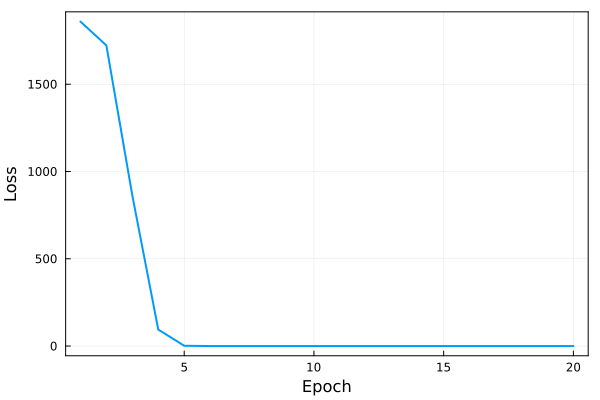

In [18]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [19]:
println("Ground-truth epsilon: ", epsilon_true)
println("Estimate epsilon:     ", m.P[1])

println("Ground-truth sigma: ", sigma_true)
println("Estimate sigma:     ", m.P[2])

Ground-truth epsilon: 8.0
Estimate epsilon:     9.02943126319367
Ground-truth sigma: 10.0
Estimate sigma:     9.062426279474757
